# NVIDIA Stock Price Prediction with Two LSTM Models

In [1]:
# 1. Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
# 2. Load and Prepare Data
data = pd.read_csv(r'C:\Users\ASUS\Downloads\IIM Data Science\Code\RNN\dataset\NVDA_2.csv', parse_dates=['Date'])
data.sort_values('Date', inplace=True)
# We only need the closing price for LSTM models
dates = data['Date'].values
close_prices = data['Close'].values.reshape(-1, 1)
data.head()

,Unnamed: 0,Date,Close,High,Low,Open,Volume
0,0,2023-01-03,14.303281,14.983724,14.084460,14.838842,401277000
1,1,2023-01-04,14.736923,14.840838,14.229340,14.555073,431324000
2,2,2023-01-05,14.253320,14.552075,14.136415,14.479135,389168000
3,3,2023-01-06,14.846835,14.997712,14.022511,14.462150,405044000
4,4,2023-01-09,15.615205,16.042854,15.128603,15.271487,504231000


In [3]:
# 3. Scale Data
def scale_series(series):
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled = scaler.fit_transform(series)
    return scaled, scaler

scaled_close, close_scaler = scale_series(close_prices)

In [4]:
# 4. Function to Create Sequences
def make_sequences(series, n_steps):
    X, y = [], []
    for i in range(n_steps, len(series)):
        X.append(series[i - n_steps:i, 0])  # past n_steps
        y.append(series[i, 0])             # next value
    X = np.array(X)
    y = np.array(y)
    return X.reshape((X.shape[0], X.shape[1], 1)), y

In [5]:
# 5. Split Data into Train/Test
n_steps = 60
X, y = make_sequences(scaled_close, n_steps)
split_idx = int(len(X) * 0.8)
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

In [6]:
# 6. Define a Function to Build and Train an LSTM Model
def train_lstm(X_tr, y_tr, X_val, y_val, units=50, drop=0.2, epochs=20, batch=32):
    model = Sequential([
        LSTM(units, return_sequences=True, input_shape=(X_tr.shape[1], 1)),
        Dropout(drop),
        LSTM(units),
        Dropout(drop),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    history = model.fit(
        X_tr, y_tr,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=batch,
        callbacks=[early_stop],
        verbose=0
    )
    return model, history

c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


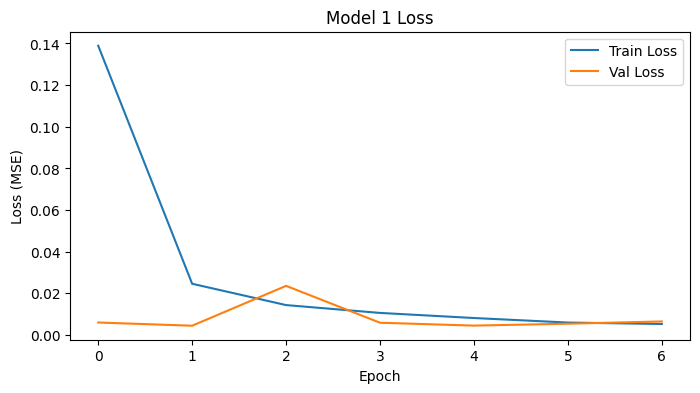

In [7]:
# 7. Model 1: Simple LSTM
model1, hist1 = train_lstm(X_train, y_train, X_test, y_test,
                           units=50, drop=0.2, epochs=30, batch=64)

# 8. Plot Training Loss for Model 1
plt.figure(figsize=(8,4))
plt.plot(hist1.history['loss'], label='Train Loss')
plt.plot(hist1.history['val_loss'], label='Val Loss')
plt.title('Model 1 Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.show()

In [8]:
# 9. Predict and Inverse Transform
pred1 = model1.predict(X_test)
# Inverse scaling to original values
pred1_inv = close_scaler.inverse_transform(pred1)
actual_inv = close_scaler.inverse_transform(y_test.reshape(-1,1))

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step


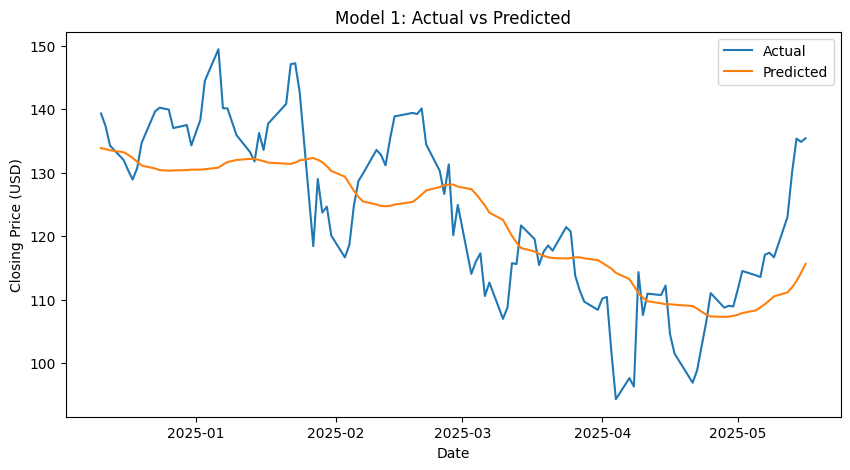

In [9]:
# 10. Plot Actual vs Predicted for Model 1
plt.figure(figsize=(10,5))
plt.plot(dates[split_idx + n_steps:], actual_inv, label='Actual')
plt.plot(dates[split_idx + n_steps:], pred1_inv, label='Predicted')
plt.title('Model 1: Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Closing Price (USD)')
plt.legend()
plt.show()

In [10]:
# 11. Evaluate Model 1
rmse1 = np.sqrt(mean_squared_error(actual_inv, pred1_inv))
mae1 = mean_absolute_error(actual_inv, pred1_inv)
r2_1 = r2_score(actual_inv, pred1_inv)
print(f"Model 1 - RMSE: {rmse1:.2f}, MAE: {mae1:.2f}, R²: {r2_1:.2f}")

Model 1 - RMSE: 9.05, MAE: 7.36, R²: 0.54


c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


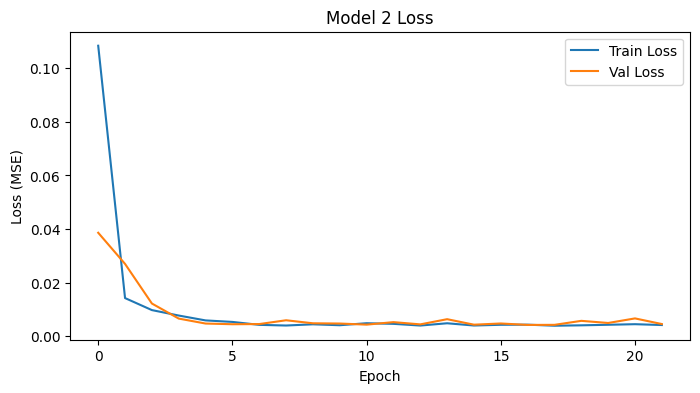

In [11]:
# 12. Model 2: Deeper LSTM (additional layer)
model2, hist2 = train_lstm(X_train, y_train, X_test, y_test,
                           units=100, drop=0.3, epochs=30, batch=64)

# 13. Plot Training Loss for Model 2
plt.figure(figsize=(8,4))
plt.plot(hist2.history['loss'], label='Train Loss')
plt.plot(hist2.history['val_loss'], label='Val Loss')
plt.title('Model 2 Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.show()

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step


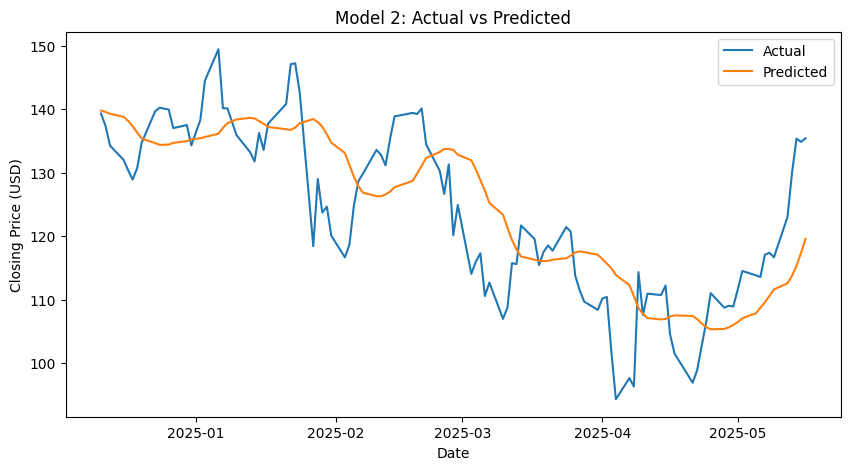

In [12]:
# 14. Predict and Plot for Model 2
pred2 = model2.predict(X_test)
pred2_inv = close_scaler.inverse_transform(pred2)

plt.figure(figsize=(10,5))
plt.plot(dates[split_idx + n_steps:], actual_inv, label='Actual')
plt.plot(dates[split_idx + n_steps:], pred2_inv, label='Predicted')
plt.title('Model 2: Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Closing Price (USD)')
plt.legend()
plt.show()

In [13]:
# 15. Evaluate Model 2
rmse2 = np.sqrt(mean_squared_error(actual_inv, pred2_inv))
mae2 = mean_absolute_error(actual_inv, pred2_inv)
r2_2 = r2_score(actual_inv, pred2_inv)
print(f"Model 2 - RMSE: {rmse2:.2f}, MAE: {mae2:.2f}, R²: {r2_2:.2f}")

Model 2 - RMSE: 8.74, MAE: 7.17, R²: 0.57


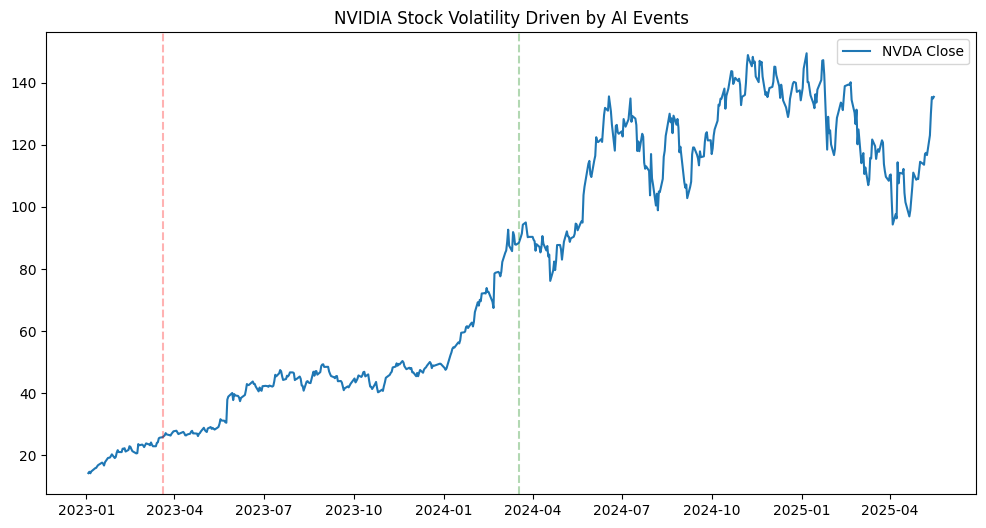

In [14]:
# Add to your code (after loading data)
plt.figure(figsize=(12, 6))
plt.plot(dates, close_prices, label='NVDA Close')
plt.axvline(x=pd.Timestamp('2023-03-20'), color='r', linestyle='--', alpha=0.3)  # GTC 2023
plt.axvline(x=pd.Timestamp('2024-03-18'), color='g', linestyle='--', alpha=0.3)  # Blackwell
plt.title('NVIDIA Stock Volatility Driven by AI Events')
plt.legend(); plt.show()

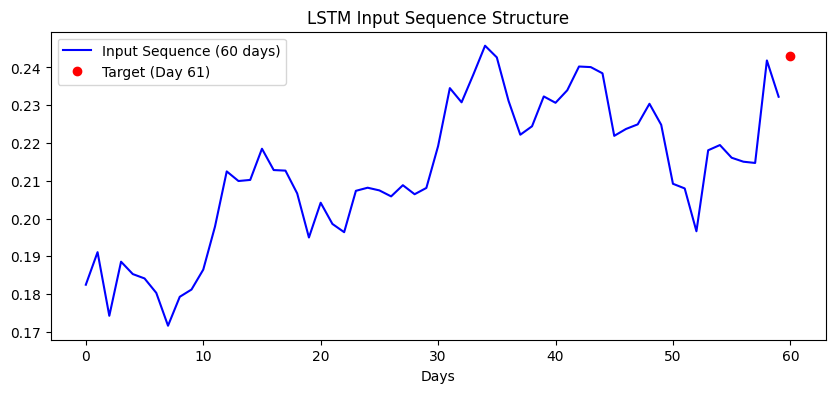

In [15]:
# Add after make_sequences()
plt.figure(figsize=(10, 4))
plt.plot(range(60), scaled_close[100:160], 'b-', label='Input Sequence (60 days)')
plt.plot([60], scaled_close[160], 'ro', label='Target (Day 61)')
plt.title('LSTM Input Sequence Structure')
plt.xlabel('Days'); plt.legend(); plt.show()

In [16]:
import visualkeras
visualkeras.layered_view(model2, scale_xy=10).show()  # Save as high-res PNG

c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\visualkeras\layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


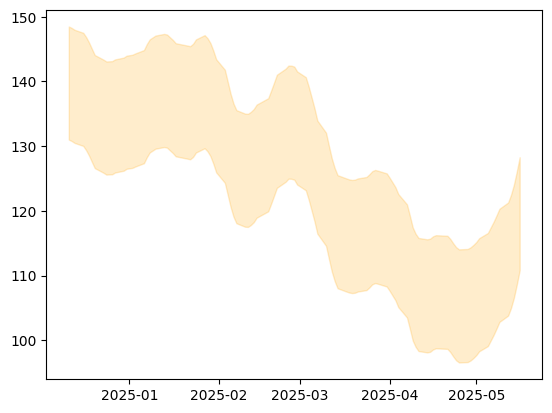

In [17]:
# Add to your prediction plot code
plt.fill_between(dates[split_idx + n_steps:], 
                 pred2_inv.flatten() - rmse2, 
                 pred2_inv.flatten() + rmse2, 
                 alpha=0.2, color='orange', label='±RMSE')

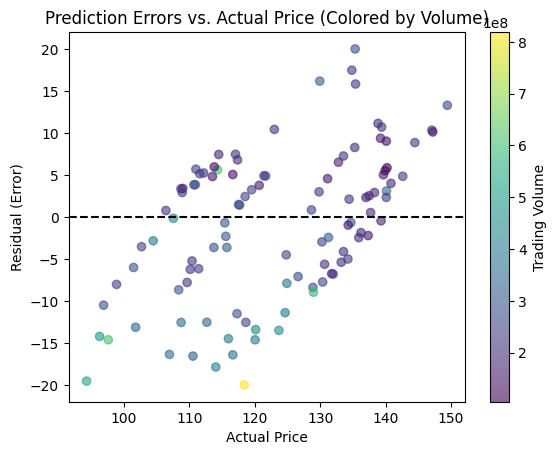

In [18]:
residuals = actual_inv - pred2_inv
plt.scatter(close_prices[split_idx + n_steps:], residuals, c=data['Volume'][split_idx + n_steps:], alpha=0.6)
plt.colorbar(label='Trading Volume')
plt.axhline(0, color='k', linestyle='--')
plt.title('Prediction Errors vs. Actual Price (Colored by Volume)')
plt.xlabel('Actual Price'); plt.ylabel('Residual (Error)'); plt.show()

In [20]:
# After prediction, add:
from tf_keras_vis.saliency import Saliency
saliency = Saliency(model2)
heatmap = saliency(loss, seed_input=X_test[0:1])
plt.imshow(heatmap[0], aspect='auto', cmap='hot')
plt.title('Attention Heatmap: Days Influencing Prediction')

NameError: name 'loss' is not defined

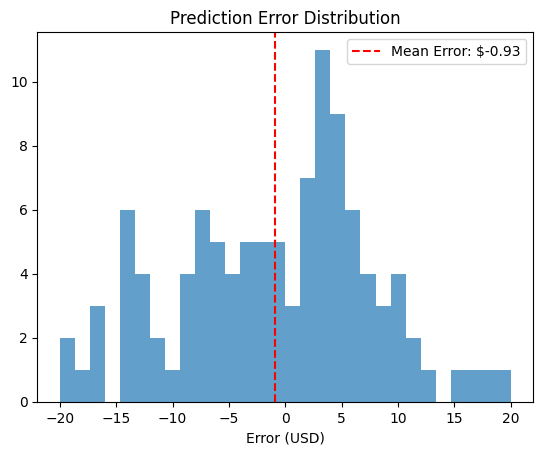

In [21]:
plt.hist(residuals, bins=30, alpha=0.7)
plt.axvline(x=np.mean(residuals), color='r', linestyle='--', label=f'Mean Error: ${np.mean(residuals):.2f}')
plt.title('Prediction Error Distribution'); plt.xlabel('Error (USD)'); plt.legend()

In [22]:
from sklearn.inspection import permutation_importance
r = permutation_importance(model2, X_test, y_test, n_repeats=10)
plt.bar(range(len(r.importances_mean)), r.importances_mean)
plt.title('Permutation Feature Importance (Synthetic Test)')

ValueError: Found array with dim 3. None expected <= 2.